In [1]:
import numpy as np
import json
import os
import random
import matplotlib.pyplot as plt

## Loading data to use as reference (annotazioni fatte a mano da Andrea)

In [2]:
annotations_qa_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_qa/texts'
with open(os.path.join(annotations_qa_root, 'spatial_gpt4point_qa_no_vec.json'), 'r') as f:
    annotations_qa = json.load(f)
print(len(annotations_qa))
print(annotations_qa[0])  

annotations_cap_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_cap/texts'
with open(os.path.join(annotations_cap_root, 'spatial_gpt4point_cap.json'), 'r') as f:
    annotations_cap = json.load(f)
print(len(annotations_cap))
print(annotations_cap[0])

data_root = '/media/data7/DATASET/objanerf_text_evaluation_data/imgs_from_objaverse/gpt4point_test'

190
{'object_id': '44795759d6144f61990796c02088665f', 'conversations': [{'from': 'human', 'value': 'What is the rabbit wearing around its neck?\nA: A red necklace\nB: A red tie\nC: A red scarf'}, {'from': 'gpt', 'value': 'C: A red scarf'}]}
100
{'object_id': '1915ece903a5406d8b59b3af3954b943', 'conversations': [{'from': 'human', 'value': '<point>\nProvide a very detailed description of the object knowing that its caption is: "A low-polygon, golden trophy with a small handle base.". Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.'}, {'from': 'gpt', 'value': "The trophy is a three-dimensional object with a smooth, golden surface. It has a cylindrical body with a slightly flared top and a very thin circular base. The trophy has two handles: one on each side. The trophy's design is simplistic, with no visible textures or patterns, giving it a uniform a

In [3]:
object_ids = [annotation['object_id'] for annotation in annotations_qa]
object_ids = list(set(object_ids))
print(len(object_ids))

random_id = random.choice(object_ids)
print(random_id)

98
346d74713027437992db6afabb768694


346d74713027437992db6afabb768694
Q 1: Which component occupies the central part of the stem?
A: A black sphere
B: A white sphere
C: An elongated black cylinder
====  B: A white sphere  ==== 


Question: <point>
Provide a very detailed description of the object knowing that its caption is: A black light fixture, equipped with a white lampshade, placed on a gray base.. Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.
GT:  The object is a black upright lamp with a white shade. The shade is attached to the stem, which is black and white in color. The stem has an elongated shape with spherical, cylindrical and conical components in black and white mounted on top of each other. In particular, a white sphere occupies the central part of the stem. The shade is white with black edges. It appears to be a standard size, and covers the light source.


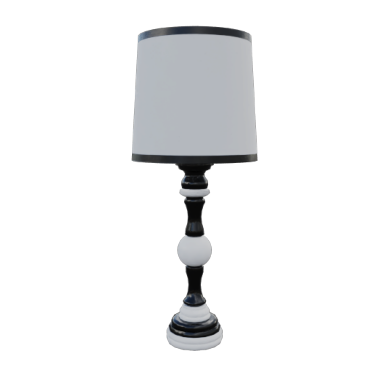

In [4]:
qa = [annotation for annotation in annotations_qa if annotation['object_id'] == random_id]
cap = [annotation for annotation in annotations_cap if annotation['object_id'] == random_id]
#print('QA annotations:', qa[0]['conversations'][0]['value'])
print(random_id)
for i, q in enumerate(qa):
    print(f'Q {i+1}: {q["conversations"][0]["value"]}')
    print('==== ', q['conversations'][1]['value'], ' ==== ')
    print('\n')

print('Question:', cap[0]['conversations'][0]['value'])
print('GT: ', cap[0]['conversations'][1]['value'])
image_path = os.path.join(data_root, random_id, '018.png')
plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

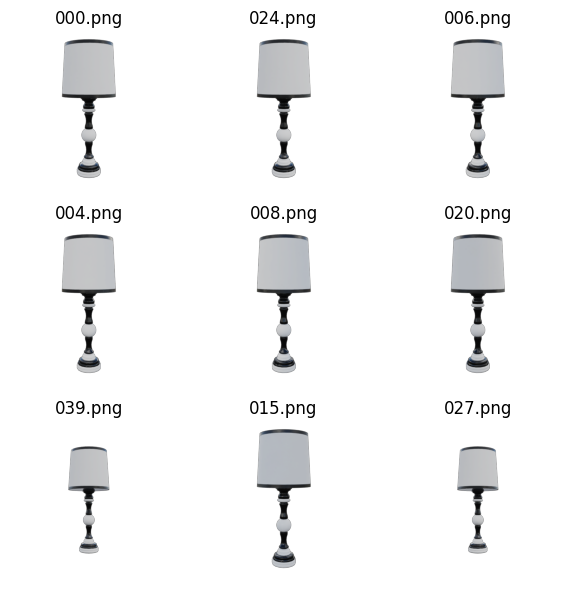

In [5]:
# visualize a grid with all the images of the object
def visualize_object_images(object_id, data_root, num_images=9):
    object_path = os.path.join(data_root, object_id)
    image_files = [f for f in os.listdir(object_path) if f.endswith('.png')]
    random.shuffle(image_files)
    image_files = image_files[:num_images]

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))
    axs = axs.flatten()

    for ax, img_file in zip(axs, image_files):
        img_path = os.path.join(object_path, img_file)
        ax.imshow(plt.imread(img_path))
        ax.axis('off')
        ax.set_title(img_file)

    plt.tight_layout()
    plt.show()

visualize_object_images(random_id, data_root, num_images=9)

# Run VLM on input images

In [6]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from transformers import pipeline
import torch

/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
os.system('export CUDA_HOME=/usr/local/cuda-12.4')
os.system('export PATH=$CUDA_HOME/bin:$PATH')
os.system('export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH')

0

In [8]:
model_id = "llava-hf/llava-interleave-qwen-7b-hf"
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16)

In [9]:
# load LLaVA model

device = 'cuda:2'
llava = LlavaForConditionalGeneration.from_pretrained(
        model_id, 
        low_cpu_mem_usage=True, 
        quantization_config=bnb_config, 
        device_map=device
    )

llava.eval()

Loading checkpoint shards: 100%|██████████| 4/4 [00:14<00:00,  3.52s/it]


LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(729, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-25): 26 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-

In [10]:
llava_processor = AutoProcessor.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
cap[0]['conversations'][1]['value']

'The object is a black upright lamp with a white shade. The shade is attached to the stem, which is black and white in color. The stem has an elongated shape with spherical, cylindrical and conical components in black and white mounted on top of each other. In particular, a white sphere occupies the central part of the stem. The shade is white with black edges. It appears to be a standard size, and covers the light source.'

In [28]:
image_names = ['000.png', '010.png', '015.png', '020.png']
data_root = "media7link/gpt4point_test/"
question = f"""
### Task:
Generate one multiple-choice question about the object(s) or scene depicted in the provided images.

### Constraints:
1.  **Detailed Questions:** The questions should require careful observation of the image.
2.  **Distinct Options:** Provide three distinct options for each question.
3.  **One Correct Answer:** Only one option must be clearly correct based on the image.

### Output Format:
For each question-answer pair, you MUST follow this format precisely:
Q: [Your Question Text Here]
1. [Option 1 Text]
2. [Option 2 Text]
3. [Option 3 Text]
A: [Correct Option Number]. [Text of Correct Option]

Now, based on the provided images, generate a question and the relative answer following all the above instructions and the specified format.
"""
body_html = ""

random_id = "ba341c4ce89647ea9f6996ec58e3eacf"
for i in range(10):
    images = [os.path.join(data_root, random_id, img_name) for img_name in image_names]
    random_id = random.choice(object_ids)

    # build conversation
    conversation = [
                    {
                        "role": "user",
                        "content": [
                            *[{"type": "image", "image": img} for img in images],
                            {"type": "text", "text": question}
                        ],
                    }
                ]
                
    # Process with VLM
    inputs = llava_processor.apply_chat_template(
        [conversation], 
        add_generation_prompt=True, 
        tokenize=True, 
        return_dict=True, 
        return_tensors="pt"
    ).to(device)

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate with optimized parameters
    generate_ids = llava.generate(**inputs, max_new_tokens=128, do_sample=True, temperature=0.1)
    # generate_ids = llava.generate(**inputs, max_new_tokens=128)
    outputs = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    model_response = outputs[0].split('\n\nassistant\n', 1)[1]

    images_html = ""

    for imagepath in images:
        images_html += f"""<img src="{imagepath}" style="width:200px;" alt="{imagepath}">"""

    output_html = f"""<pre class="pre-wrap">{model_response}</pre>"""

    body_html += images_html + output_html

full_html_path = "llavagen.html"

full_html = f"""
<!DOCTYPE html>
<html>
<head>
<title>LLaVA generation output</title>
  <style>
    .pre-wrap {{
      white-space: pre-wrap;   /* Preserves whitespace and wraps text */
      word-wrap: break-word;   /* Ensures long words break */
      max-width: 800px;          /* Maximum width (could also use px or rem) */
    }}
  </style>
</head>
<body>
<h2>Prompt:</h2>
<pre>{question}</pre>
<h2>Outputs:</h2>
{body_html}
</body>
</html> 
"""

with open(full_html_path, "w", encoding="utf-8") as f:
    f.write(full_html)


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
